<a href="https://colab.research.google.com/github/AdrienLiard/GANs/blob/main/Gan_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
import keras
from keras.layers import Conv2D, Input, Activation, Dropout, Flatten, Dense, BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose
from keras.models import Model
from keras.optimizers import RMSprop
from keras.initializers import RandomNormal
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import Callback, ModelCheckpoint

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
class Gan():
    
    def __init__(self, input_size):
        
        self.input_size = input_size
        
        kernel_initializer = RandomNormal(mean=0., stddev=0.02)
        
        # Discriminator
                
        dis_conv_filters = [64, 64, 128, 128]
        dis_conv_kernel = [5, 5, 5, 5]
        dis_conv_strides = [2, 2, 2, 1]
        dis_dropout = 0.4
        dis_momentum = 0.9
        dis_lr = 0.0008
        
        dis_input = Input(self.input_size)
        x = dis_input
        
        for i, c in enumerate(zip(dis_conv_filters, dis_conv_kernel, dis_conv_strides)):
            f, k, s = c
            x = Conv2D(f, kernel_size=k, strides=s, padding="same", name=f"disc_conv_{i}")(x)
            #x = BatchNormalization(momentum=dis_momentum)(x)
            x = Activation('relu')(x)
            x = Dropout(rate = dis_dropout)(x)
        x = Flatten()(x)
        dis_output = Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)(x)
        self.discriminator = Model(dis_input, dis_output)
        
        
        
        # Generator 
        self.z_dim = 100
        gen_initial_dense_size = (7, 7, 64)
        gen_momentum = 0.9
        gen_conv = [{"upsample": True, "filters": 128, "kernel": 5, "strides": 1},
                    {"upsample": True, "filters": 64, "kernel": 5, "strides": 1},
                    {"upsample": False, "filters": 64, "kernel": 5, "strides": 1},
                    {"upsample": False, "filters": 1, "kernel": 5, "strides": 1},
                   ]
        gen_lr = 0.0004
        
        gen_input = Input((self.z_dim,))
        x = gen_input
        
        x = Dense(np.prod(gen_initial_dense_size))(x)
        x = BatchNormalization(momentum=gen_momentum)(x)
        x = Activation('relu')(x)
        x = Reshape(gen_initial_dense_size)(x)
        
        for i, conv in enumerate(gen_conv):
            if conv["upsample"]:
                x = UpSampling2D()(x)
                x = Conv2D(conv["filters"],
                           kernel_size=conv["kernel"],
                           strides=conv["strides"],
                           kernel_initializer=kernel_initializer,
                           padding="same")(x)
            else:
                x = Conv2DTranspose(conv["filters"],
                                    kernel_size=conv["kernel"],
                                    strides=conv["strides"],
                                    padding="same",
                                    kernel_initializer=kernel_initializer)(x)
            if i < len(gen_conv)-1:
                x = BatchNormalization(momentum=gen_momentum)(x)
                x = Activation('relu')(x)
            else:
                x = Activation('tanh')(x)
    
                
        self.generator = Model(gen_input, x)
        
        self.discriminator.compile(
        optimizer=RMSprop(dis_lr)
        , loss = 'binary_crossentropy'
        ,  metrics = ['accuracy']
        )
        
        self.discriminator.trainable = False
        model_input = Input(shape=(self.z_dim,), name="model_input")
        model_output = self.discriminator(self.generator(model_input))
        self.model = Model(model_input, model_output)
        self.model.compile(optimizer=RMSprop(lr=gen_lr), loss='binary_crossentropy', metrics=['accuracy'])

        
class Dataset():       
    def __init__(self, path, batch_size, max_sample=5000):
        self.path = path
        self.batch_size = batch_size
        self.dataset = np.load(path)[:max_sample]
        self.dataset = (self.dataset.astype('float32') - 127.5) / 127.5
        self.dataset = self.dataset.reshape((self.dataset.shape[0],28,28,1))
        
    def __len__(self):
        return int(len(self.dataset) / self.batch_size)
    
    def batch_fake(self, z_dim):
        #sample 
        return np.random.normal(0, 1, size=(self.batch_size, z_dim)), np.ones(shape=(self.batch_size, 1)), np.zeros(shape=(self.batch_size, 1),dtype='float32')


    def batch_real(self):
        n_batches = self.__len__()
        total_samples = n_batches * batch_size
        #sample 
        sample = np.random.choice(range(len(self.dataset)), self.batch_size, replace=False)
        return self.dataset[sample], np.ones(shape=(self.batch_size, 1))


In [4]:
gan = Gan((28,28,1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
gan.generator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3136)              12544     
_________________________________________________________________
activation_5 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       2049

In [6]:
gan.discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
disc_conv_0 (Conv2D)         (None, 14, 14, 64)        1664      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
disc_conv_1 (Conv2D)         (None, 7, 7, 64)          102464    
_________________________________________________________________
activation_2 (Activation)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0   

/tensorflow-1.15.2/python3.6/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [7]:
gan.model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_input (InputLayer)     (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         844161    
_________________________________________________________________
model_1 (Model)              (None, 1)                 720833    
Total params: 1,564,994
Trainable params: 837,377
Non-trainable params: 727,617
_________________________________________________________________


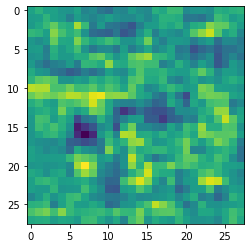

In [8]:
fake_test = gan.generator.predict(np.array(np.random.normal(0,1,size=(1,gan.z_dim))))
plt.imshow(fake_test[0,:,:,0])

In [9]:
discrim_test = gan.discriminator.predict(fake_test)
discrim_test

array([[0.5000448]], dtype=float32)

/tensorflow-1.15.2/python3.6/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/tensorflow-1.15.2/python3.6/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/tensorflow-1.15.2/python3.6/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


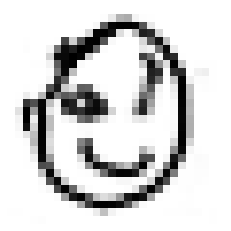

In [11]:
gan = Gan((28,28,1))

epochs = 20000
batch_size = 128
dataset = Dataset("drive/MyDrive/toy_datasets/full_numpy_bitmap_face.npy", batch_size)


    
for epoch in range(epochs):
    #train discriminator on real images
    x_train, y_train = dataset.batch_real()
    d_real_loss, d_real_acc = gan.discriminator.train_on_batch(x_train, y_train)
    
    #train disc on fake images
    fake_batch, y_train_gen, y_train_disc  = dataset.batch_fake(gan.z_dim)
    x_train = gan.generator.predict(fake_batch)
    d_fake_loss, d_fake_acc = gan.discriminator.train_on_batch(x_train, y_train_disc)
    
    #train generator
    g_loss, g_acc = gan.model.train_on_batch(fake_batch, y_train_gen)
    
    if epoch%200==0:
        plt.imshow(gan.generator.predict(fake_batch[:1])[0][:,:,0], cmap="Greys")
        plt.axis("off")
        plt.savefig(f"drive/MyDrive/images/faces/faces-epoch{epoch}.png")
    if epoch%1000==0:
        gan.model.save_weights(f"drive/MyDrive/models/gan_faces/gan_faces_epoch{epoch}.hdf5")
    
    
    
    

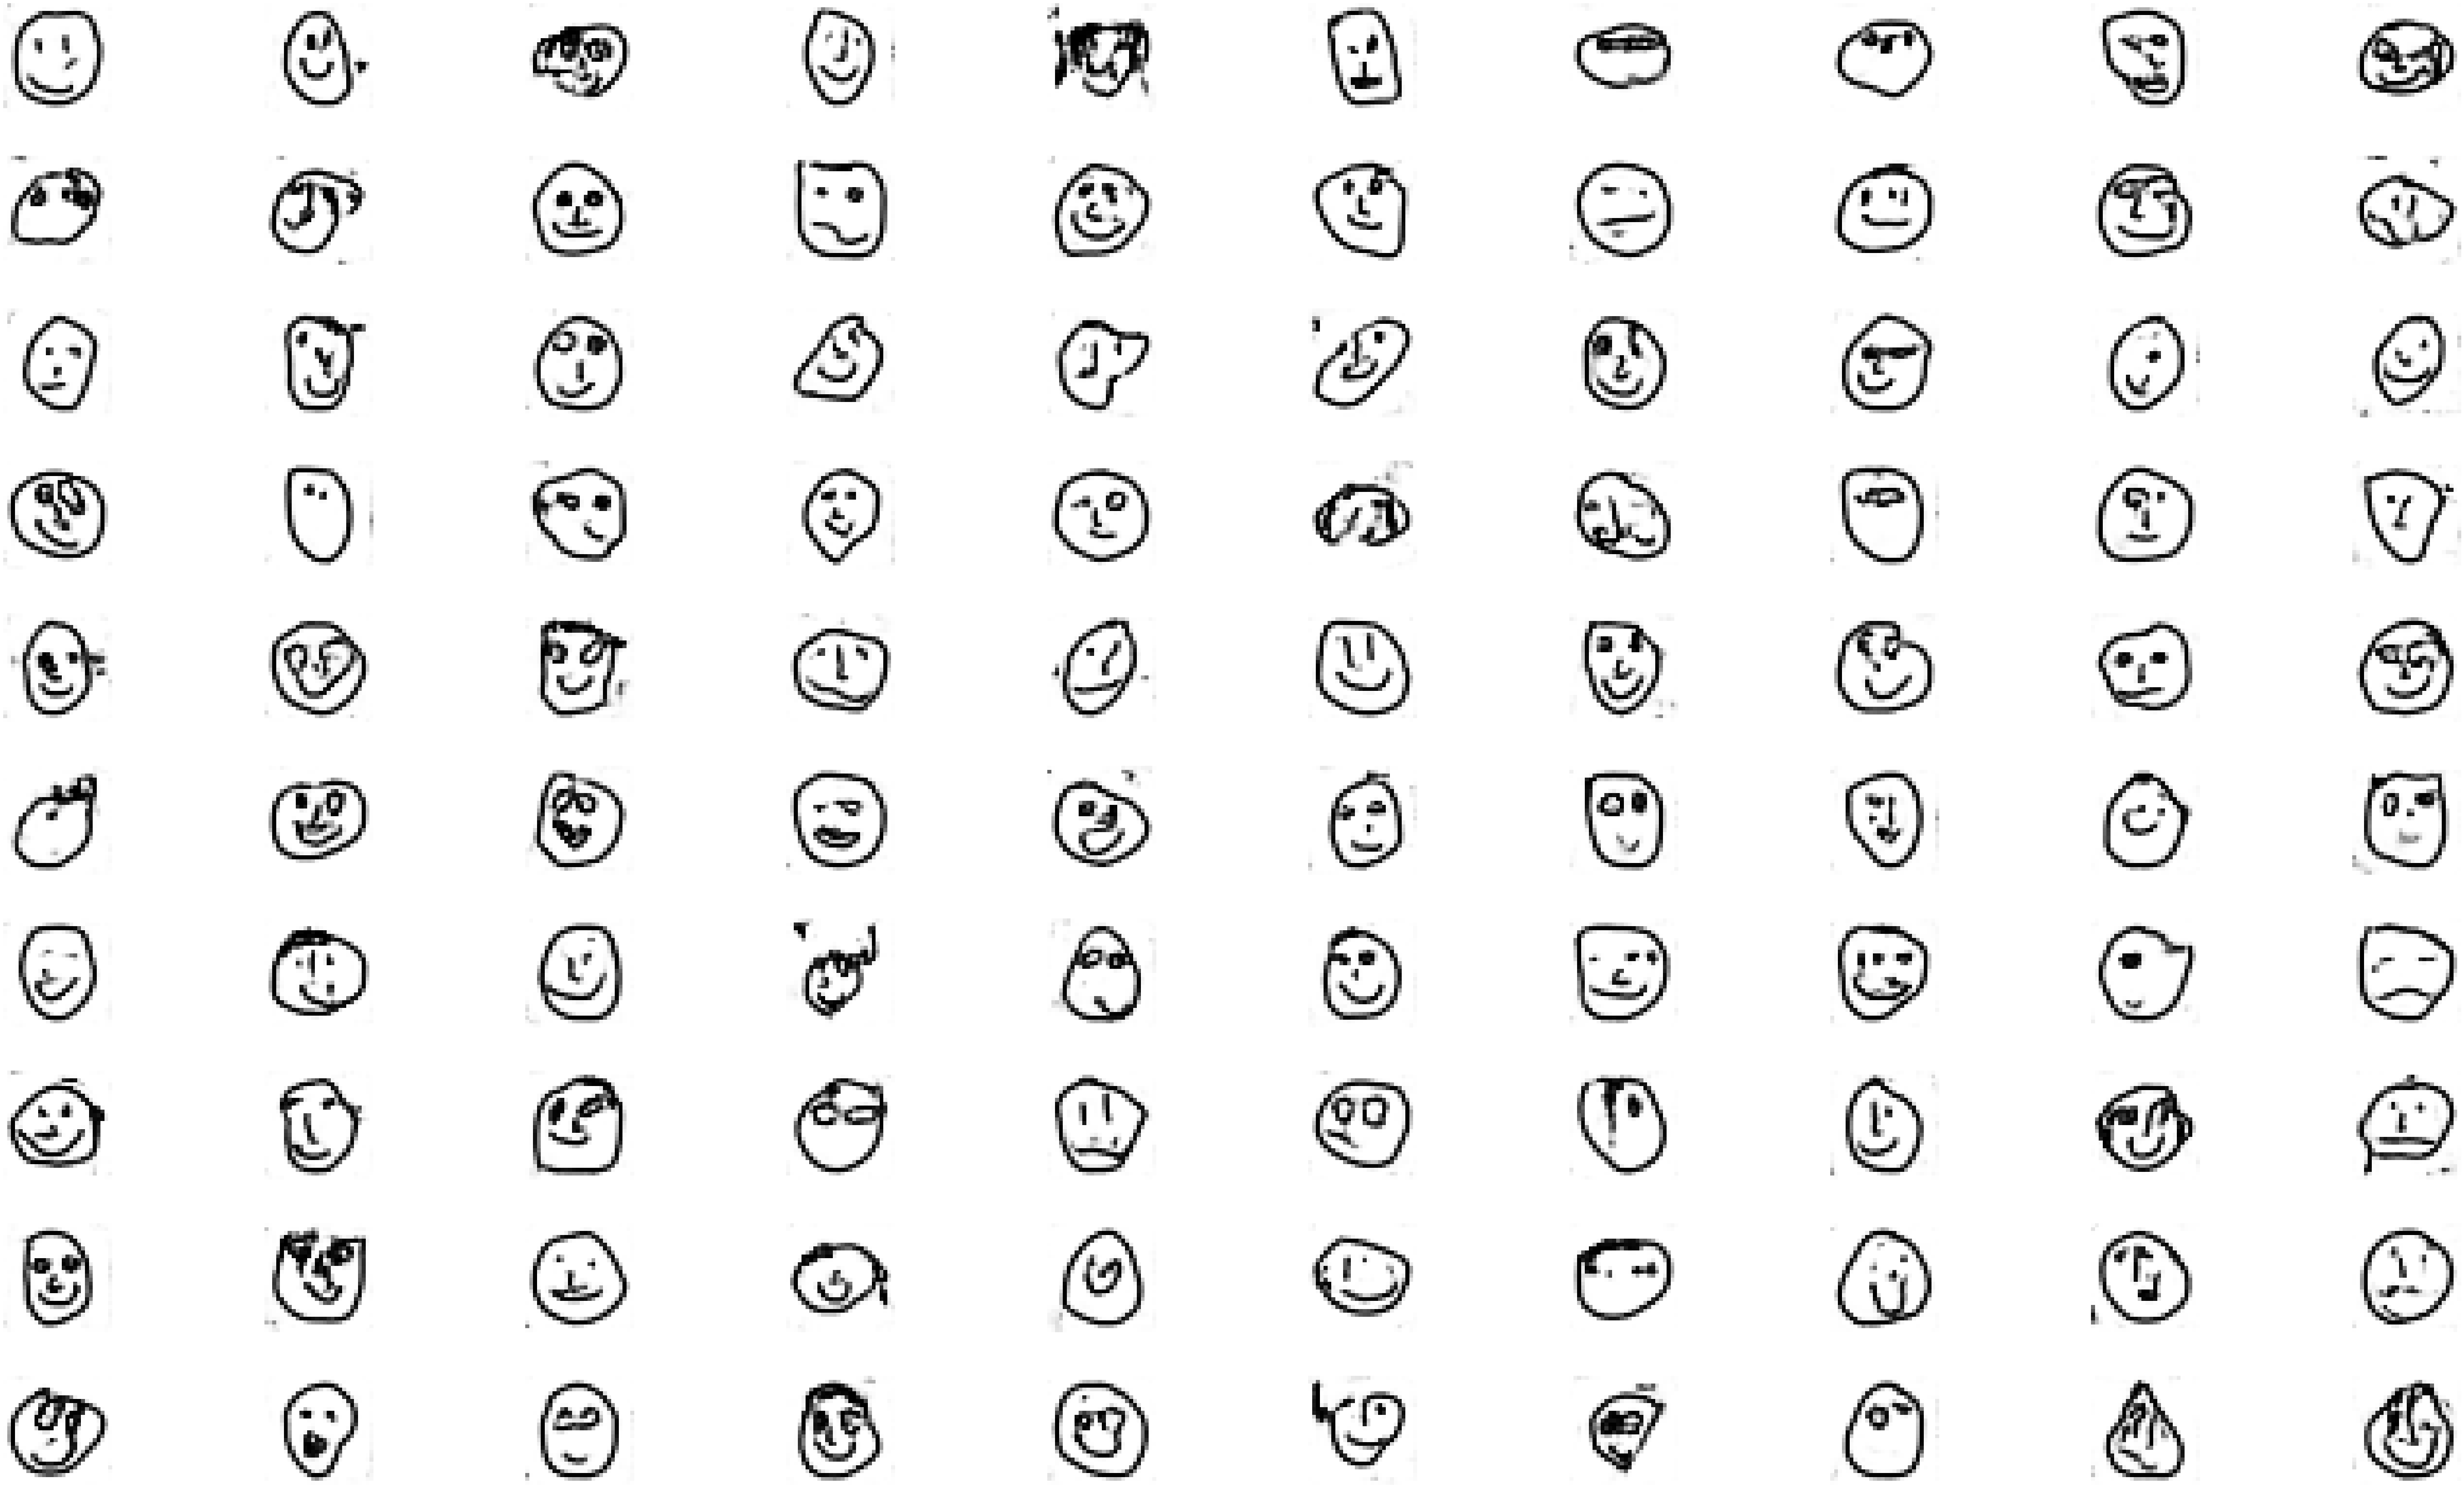

In [13]:

n_to_show = 100

znew = np.random.normal(size = (n_to_show,gan.z_dim))

generated = gan.generator.predict(np.array(znew))
fig = plt.figure(figsize=(100, 60))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_facecolor("xkcd:white")
for i in range(n_to_show):
    ax = fig.add_subplot(10, 10, i+1)
    ax.imshow(generated[i, :,:,0], cmap="Greys")
    ax.axis('off')


plt.show()


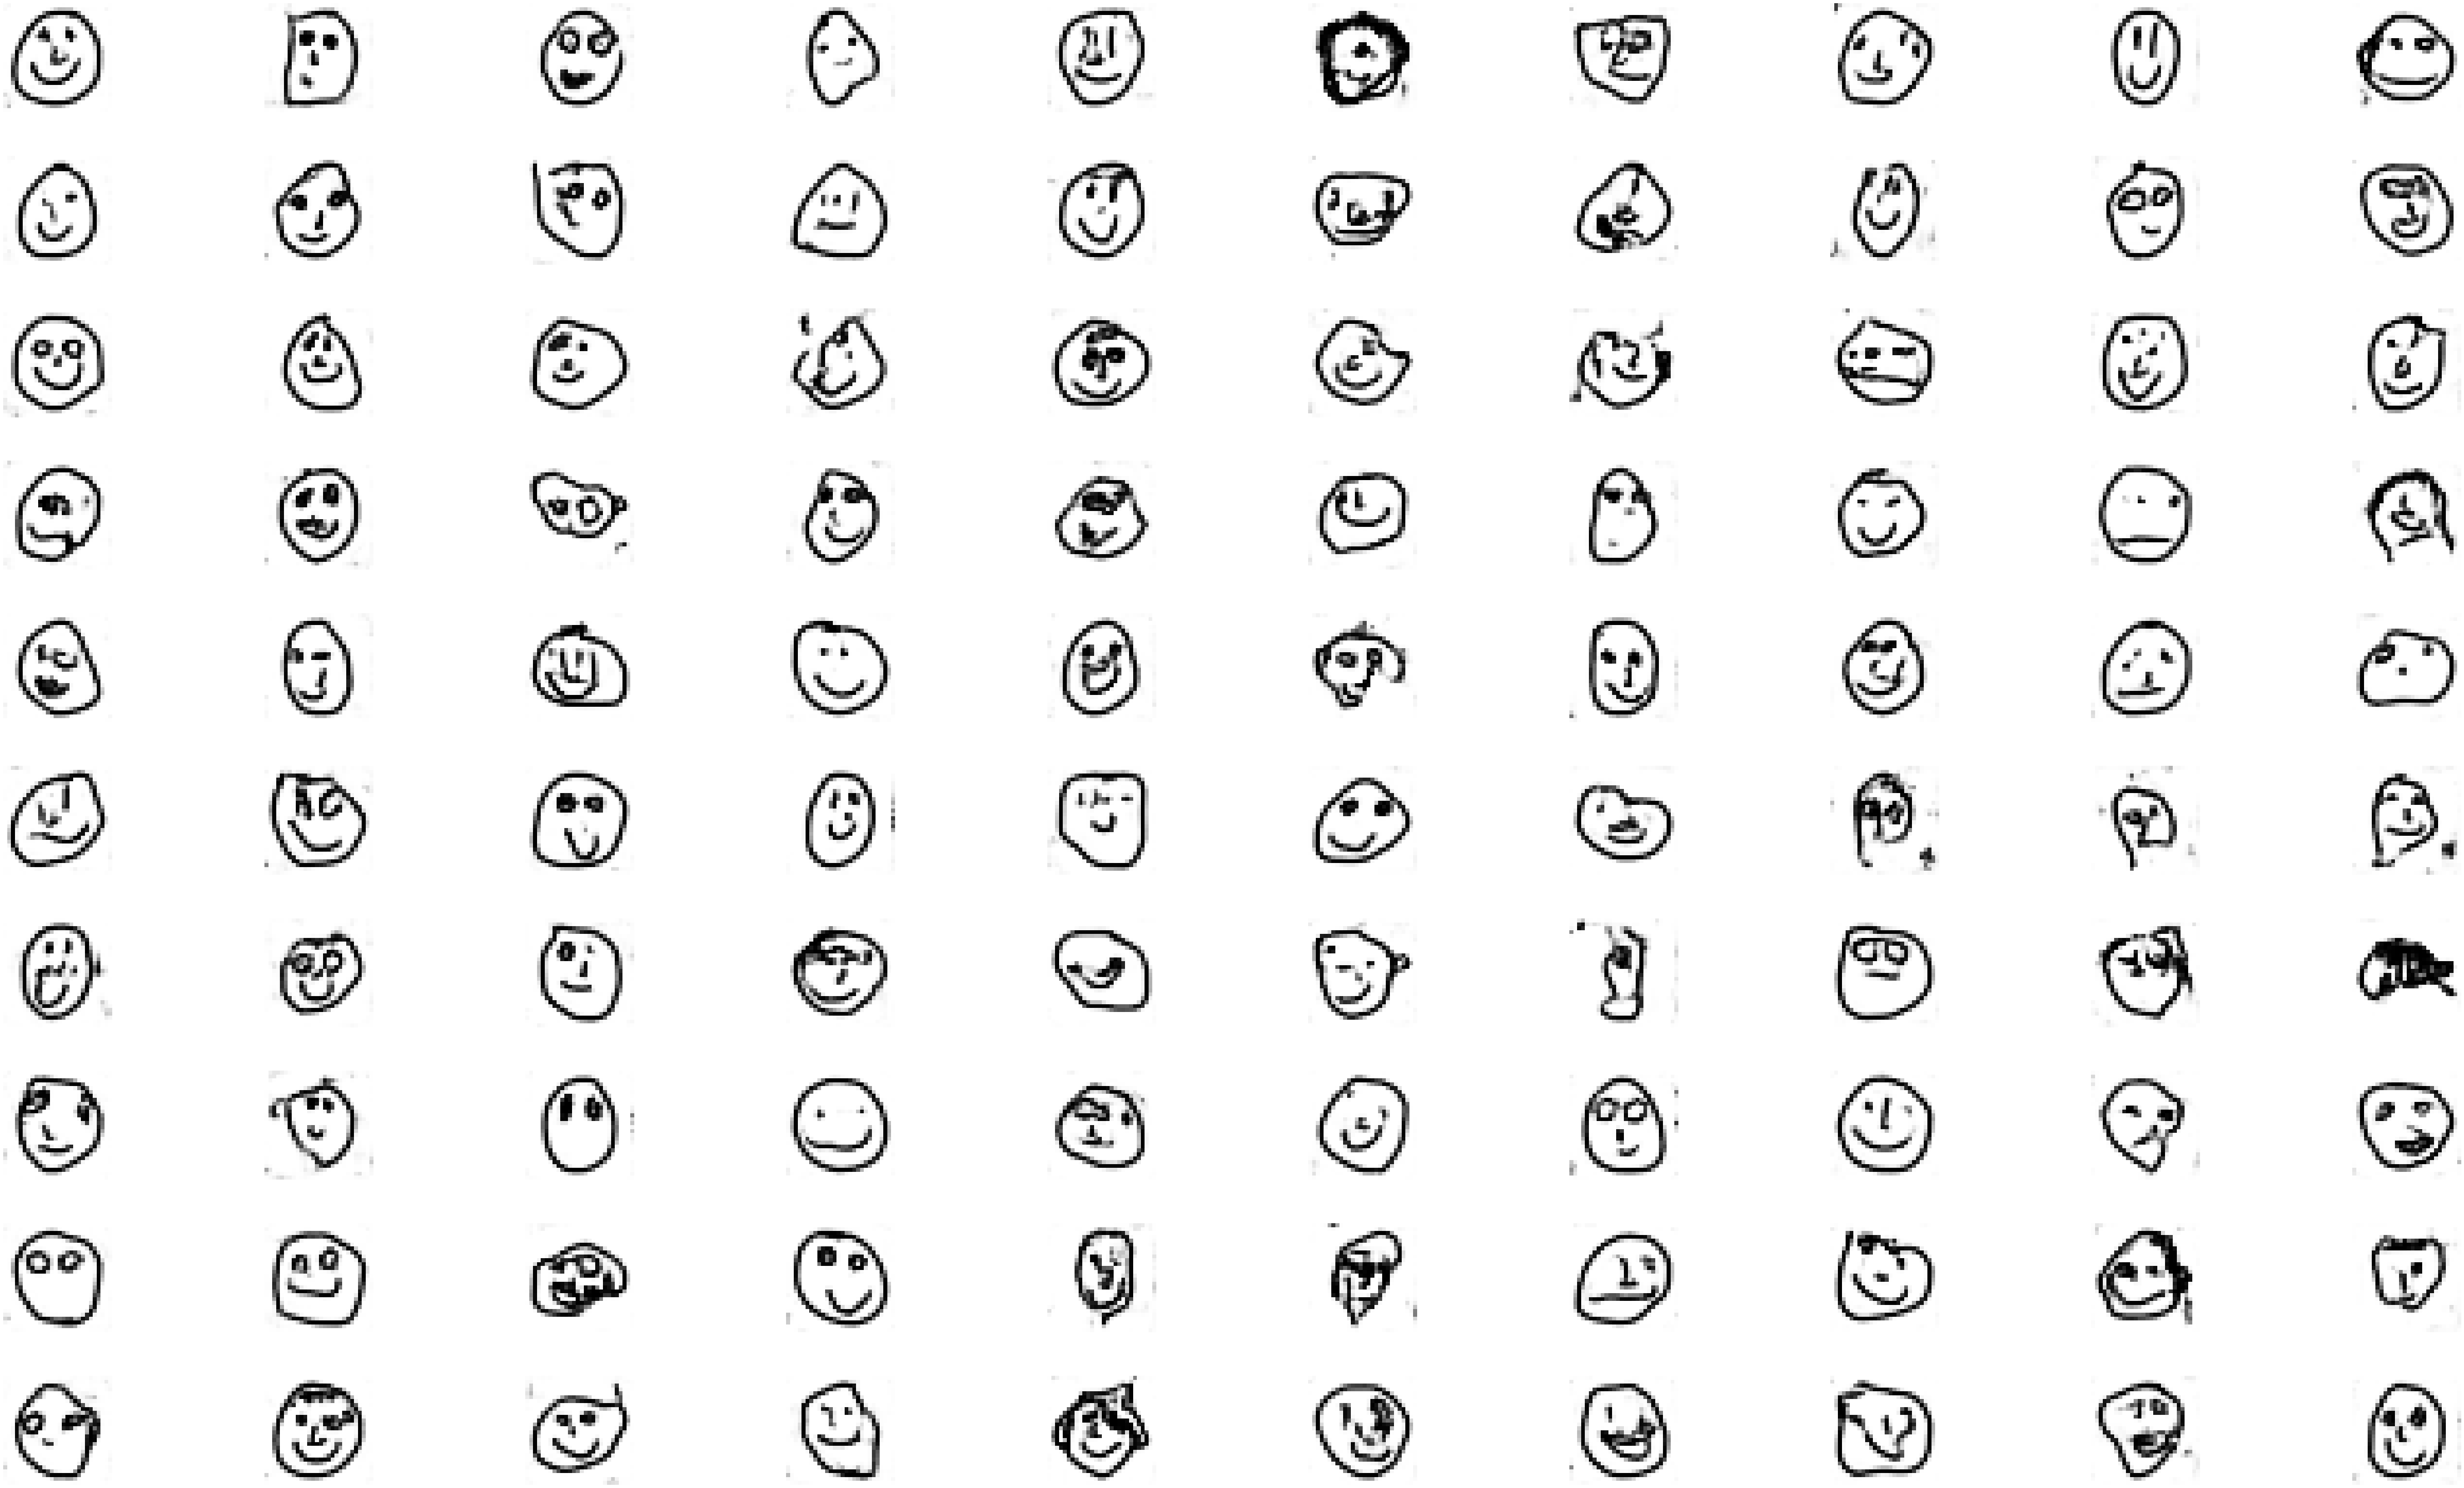

In [14]:
n_to_show = 100

znew = np.random.normal(size = (n_to_show,gan.z_dim))

generated = gan.generator.predict(np.array(znew))
fig = plt.figure(figsize=(100, 60))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.set_facecolor("xkcd:white")
for i in range(n_to_show):
    ax = fig.add_subplot(10, 10, i+1)
    ax.imshow(generated[i, :,:,0], cmap="Greys")
    ax.axis('off')


plt.show()


In [15]:
import PIL
import imageio
import os
files = os.listdir("drive/MyDrive/images/faces")
images = [imageio.imread("drive/MyDrive/images/faces/" + f) for f in files]
imageio.mimsave("drive/MyDrive/images/faces/evolution.mp4",images)